In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import time
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from structure.data import HMM_Data
from structure.model import ResBlock, ConvBlock, ConvNet, HmmConvNet, LSTMNet
from structure.utils import *

from config import DATA

torch.cuda.is_available()

True

## Data and Model

In [38]:
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

In [39]:
DATA = "/home/malbranke/data/"
DATASET = "PF00397"

In [40]:
class LSTMNet(nn.Module):
    def __init__(self, in_channels, out_channels=100, N=128, bias=True):
        super(LSTMNet, self).__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.conv1 = ResBlock(in_channels, 32, 129)
        self.conv2 = ResBlock(32, 32, 257)
        self.lstm1 = nn.LSTM(input_size=32+in_channels,
                             hidden_size=1024,
                             num_layers=1,
                             bias=True,
                             bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=2048,
                             hidden_size=1024,
                             num_layers=1,
                             bias=True,
                             bidirectional=True)
        self.conv_other = ConvBlock(nn.Conv1d, None, None,
                                    2048, 9, 1,
                                    stride=1, padding=0, dilation=1)
        self.conv_ss8 = ConvBlock(nn.Conv1d, None, None,

                                  2048, 8, 1,
                                  stride=1, padding=0, dilation=1)
        self.conv_ss3 = ConvBlock(nn.Conv1d, None, None,
                                  2048, 3, 1,
                                  stride=1, padding=0, dilation=1)


    def forward(self, x, is_empty = None):
        B,_,N = x.size()
        if is_empty is None:
            is_empty = (x.max().values != 0).int().view(B, 1, N)
        h = self.conv1(x)
        h = self.conv2(h)
        h = torch.cat([x, h], 1)
        h = h.permute(2, 0, 1)
        h = self.lstm1(h)[0]
        h = self.lstm2(h)[0].permute(1, 2, 0)

        h_other = self.conv_other(h)*is_empty
        h_ss8 = self.conv_ss8(h)*is_empty
        h_ss3 = self.conv_ss3(h)*is_empty
        return h_other, h_ss8, h_ss3


In [59]:
def collate_sequences(data):
    batch_size = len(data)
    lengths = []
    for x,t in data:
        lengths.append(len(x))
    max_length = max(lengths)
    primary = torch.zeros(batch_size, max_length, 50) 
    target = torch.zeros(batch_size, max_length, 11)
    for i, ((x,t),l) in enumerate(zip(data, lengths)):
        primary[i, :l] = torch.tensor(x)
        target[i, :l] = torch.tensor(t)
    is_empty = (primary.max(-1).values != 0).int().view(*primary.size()[:-1], 1)
    return primary, target, is_empty

In [60]:
train_dataset = HMM_Data(f"{DATA}/secondary_structure/training_set")
train_loader = DataLoader(train_dataset, batch_size = 15, collate_fn = collate_sequences,
                        shuffle = True, drop_last=True)

In [71]:
val_dataset = HMM_Data(f"{DATA}/secondary_structure/validation_set")
val_loader = DataLoader(val_dataset, batch_size = 15, collate_fn = collate_sequences,
                        shuffle=False, drop_last=False)

In [82]:
qx = 50
# del model
device = torch.device('cuda')

# del model
model = LSTMNet(qx)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.load_state_dict(torch.load(f"{DATA}/secondary_structure/model_40feats.h5"))
start = time.time()

model

LSTMNet(
  (conv1): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(50, 32, kernel_size=(129,), stride=(1,), padding=(64,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): ResBlock(
    (conv_1): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(257,), stride=(1,), padding=(128,))
      (activation): LeakyReLU(negative_slope=0.2)
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      (normalization): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lstm1): LSTM(82, 1024, bidire

## Train

In [81]:
def train(epoch):
    n_res, mean_ss3, mean_ss8, mean_box, mean_other, mean_loss, mean_ss3_acc, mean_ss8_acc = 0,0,0,0,0,0,0,0
    model.train()
    for batch_idx, (x,t,is_empty) in enumerate(train_loader):
        x = x.float().permute(0, 2, 1).to(device)
        t = t.float().permute(0, 2, 1).to(device)
        is_empty = is_empty.float().permute(0, 2, 1).to(device)
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model(x, is_empty)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x, t, is_empty = x.cpu(), t.cpu(), is_empty.cpu()
        
        ss3_acc = ((p_ss3.argmax(1) == t[:,-1])*is_empty[:,0]).int().sum()/is_empty[:,0].sum()
        ss8_acc = ((p_ss8.argmax(1) == t[:,-2])*is_empty[:,0]).int().sum()/is_empty[:,0].sum()
        ss3_loss = F.cross_entropy(p_ss3, t[:,-1].long())
        ss8_loss = F.cross_entropy(p_ss8, t[:,-2].long())
        other_loss = F.mse_loss(p_other, t[:,:9])/1500

        loss = ss3_loss + ss8_loss + other_loss
        loss.backward()
        optimizer.step()
        
        del x
        mean_ss3 = (mean_ss3*batch_idx + ss3_loss.item())/ (batch_idx+1)
        mean_ss8 = (mean_ss8*batch_idx + ss8_loss.item())/ (batch_idx+1)
        mean_other = (mean_other*batch_idx + other_loss.item())/ (batch_idx+1)
        mean_loss = (mean_loss*batch_idx + loss.item())/ (batch_idx+1)
        mean_ss3_acc = (mean_ss3_acc*n_res + N*ss3_acc.item())/ (n_res+N)
        mean_ss8_acc = (mean_ss8_acc*n_res + N*ss8_acc.item())/ (n_res+N)
        n_res += N
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Train Epoch: {epoch} [{int(100*batch_idx/len(train_loader))}%] || Time: {m} min {s} || SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc : {mean_ss8_acc:.3f} || Loss: {mean_loss:.3f} || SS3 Loss: {mean_ss3:.3f} || SS8 Loss: {mean_ss8:.3f} || Other Loss: {mean_other:.3f}'''
              , end="\r")
    m, s = int(time.time()-start)//60, int(time.time()-start)%60
    print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s}  || SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc : {mean_ss8_acc:.3f} || Loss: {mean_loss:.3f} || SS3 Loss: {mean_ss3:.3f} || SS8 Loss: {mean_ss8:.3f} || Other Loss: {mean_other:.3f}''')

In [78]:
import math
def val(epoch, thres = 0.5):
    mean_ss3_acc, mean_ss8_acc, n_res = 0,0,0
    model.eval()
    predictions, predictions2 = [],[]
    for batch_idx, (x,t,is_empty) in enumerate(val_loader):
        x = x.float().permute(0, 2, 1).to(device)
        t = t.float().permute(0, 2, 1).to(device)
        is_empty = is_empty.float().permute(0, 2, 1).to(device)
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model(x, is_empty)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x, t, is_empty = x.cpu(), t.cpu(), is_empty.cpu()
        
        p_ss3 = F.softmax(p_ss3,1)
        p = p_ss3.detach()
        
        predictions.append(p.argmax(1).numpy()[0])
        n = is_empty[:,0].sum()
        ss3_acc = ((p.argmax(1) == t[:,-1])*is_empty[:,0]).int().sum()/n
        ss8_acc = ((p_ss8.argmax(1) == t[:,-2])*is_empty[:,0]).int().sum()/n
        mean_ss3_acc = (mean_ss3_acc*n_res + n*ss3_acc.item())/ (n_res+n)
        mean_ss8_acc = (mean_ss8_acc*n_res + n*ss8_acc.item())/ (n_res+n)
        n_res += n
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Val Epoch: {epoch} [{int(100*batch_idx/len(val_loader))}%] || Time: {m} min {s} ||| SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc: {mean_ss8_acc:.3f}''', end="\r")
    print(f'''Val Epoch: {epoch} [100%] || Time: {m} min {s} || SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc: {mean_ss8_acc:.3f}''')
    return mean_ss3_acc, predictions, predictions2

## Validate

In [ ]:
max_acc = 0
for i in range(50):
    train(i)
    mean_ss3_acc, _, _ = val(i)
    if mean_ss3_acc > max_acc:
        torch.save(model.state_dict(), f"{DATA}/secondary_structure/lstm_50feats.h5")
        max_acc = mean_ss3_acc

Train Epoch: 0 [100%] || Time: 7 min 4  || SS3 Acc: 0.761 || SS8 Acc : 0.629 || Loss: 2.978 || SS3 Loss: 0.867 || SS8 Loss: 1.625 || Other Loss: 0.486
Val Epoch: 0 [100%] || Time: 8 min 10 || SS3 Acc: 0.809 || SS8 Acc: 0.678
Train Epoch: 1 [100%] || Time: 15 min 13  || SS3 Acc: 0.821 || SS8 Acc : 0.701 || Loss: 2.634 || SS3 Loss: 0.810 || SS8 Loss: 1.536 || Other Loss: 0.289
Val Epoch: 1 [100%] || Time: 16 min 18 || SS3 Acc: 0.828 || SS8 Acc: 0.714
Train Epoch: 2 [100%] || Time: 23 min 20  || SS3 Acc: 0.836 || SS8 Acc : 0.721 || Loss: 2.569 || SS3 Loss: 0.791 || SS8 Loss: 1.505 || Other Loss: 0.273
Val Epoch: 2 [100%] || Time: 24 min 26 || SS3 Acc: 0.835 || SS8 Acc: 0.719
Train Epoch: 3 [100%] || Time: 31 min 29  || SS3 Acc: 0.850 || SS8 Acc : 0.738 || Loss: 2.525 || SS3 Loss: 0.779 || SS8 Loss: 1.485 || Other Loss: 0.260
Val Epoch: 3 [100%] || Time: 32 min 34 || SS3 Acc: 0.843 || SS8 Acc: 0.731
Train Epoch: 4 [100%] || Time: 39 min 35  || SS3 Acc: 0.862 || SS8 Acc : 0.753 || Loss: 2.4

In [150]:
preds, gt = val(0)

Val Epoch: 0 [100%] || Time: 174 min 23 || SS3 Acc: 0.818


In [152]:
f = [torch.log(s[s_bar.long(), torch.arange(s.size(-1))]).sum()/s.size(-1) for s, s_bar in zip(preds, gt)]

In [153]:
confusion = [1/s.size(-1)* sum(torch.log(1+sum(C2[si_bar, j]*si[j]/si[si_bar] for j in range(3) if j != si_bar)) for si, si_bar in zip(s.t(), s_bar))  for s, s_bar in zip(preds, gt)]

In [154]:
logA = np.log(0.818)
logA = [1/s.size(-1)* sum(np.log(C[si_bar, si_bar]) for si, si_bar in zip(s.t(), s_bar))  for s, s_bar in zip(preds, gt)]

In [155]:
var = torch.exp(torch.tensor(f)+torch.tensor(logA)+torch.tensor(confusion)) - torch.exp(torch.tensor(f))

(array([  2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   1.,
          2.,   4.,   1.,   3.,   7.,  14.,   8.,  25.,  26.,  34.,  40.,
         59.,  69.,  70.,  81., 103., 100., 109., 119., 107., 121., 106.,
         95.,  94.,  96.,  67.,  74.,  59.,  56.,  59.,  32.,  36.,  33.,
         30.,  17.,  29.,  23.,  19.,  15.,  16.,  13.,   7.,   9.,   2.,
          7.,   6.,   3.,   7.,   7.,   8.,   3.,   2.,   4.,   1.,   3.,
          1.,   0.,   0.,   3.,   2.,   0.,   2.,   1.,   1.,   1.,   2.,
          2.,   0.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-0.23235669, -0.22824871, -0.22414073, -0.22003275, -0.21592477,
        -0.21181678, -0.2077088 , -0.20360082, -0.19949284, -0.19538486,
        -0.19127688, -0.1871689 , -0.18306092, -0.17895294, -0.17484496,
        -0.17073698, -0.166629  , -0.16252102, -0.15841304, -0.15430506,
        -0.15019708, -0.14

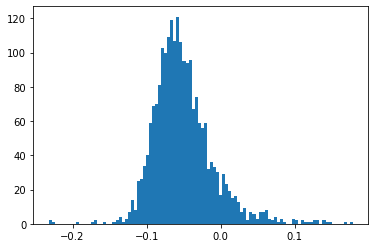

In [156]:
plt.hist(var, bins = 100)

In [45]:
from sklearn.metrics import confusion_matrix

In [48]:
C = confusion_matrix(gt, preds, normalize = "pred")
C

array([[0.88861309, 0.0216662 , 0.11537582],
       [0.01268228, 0.81835337, 0.12601533],
       [0.09870462, 0.15998043, 0.75860885]])

In [99]:
C2 = C.copy()
for i in range(3):
    C2[i,:] /= C2[i,i]

In [100]:
C2

array([[1.        , 0.02438204, 0.12983808],
       [0.01549732, 1.        , 0.15398645],
       [0.13011267, 0.21088658, 1.        ]])

### Run

In [ ]:
for i in range(50):
    train(i)
    val(i)

Train Epoch: 0 [100%] || Time: 12 min 51  || SS3 Acc: 0.843 || Loss: 0.360 
Val Epoch: 0 [100%] || Time: 12 min 57 || SS3 Acc: 0.813
Train Epoch: 1 [100%] || Time: 14 min 23  || SS3 Acc: 0.848 || Loss: 0.344 
Val Epoch: 1 [100%] || Time: 14 min 30 || SS3 Acc: 0.815
Train Epoch: 2 [100%] || Time: 15 min 55  || SS3 Acc: 0.852 || Loss: 0.330 
Val Epoch: 2 [100%] || Time: 16 min 1 || SS3 Acc: 0.8178


In [13]:
torch.save(model.state_dict(), f"{DATA}/secondary_structure/model_40feats.h5")

In [50]:
from random import shuffle

idxs = torch.tensor(range((len(train_dataset))))
shuffle(idxs)
idxs

tensor([   0,    0,    2,  ..., 3243, 3322, 3503])

## Test/Use

In [8]:
def test(epoch, thres = 0.5):
    mean_ss3_acc, mean_ss8_acc, n_res = 0,0,0
    model.eval()
#     denoiser.eval()
    predictions = []
    for batch_idx, data in enumerate(test_loader):
#         if batch_idx == 300:
#             break
        x = data.float().permute(0, 2, 1).to(device)[:,:40]
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model(x)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x = x.cpu()
        
        p_ss3 = F.softmax(p_ss3,1)
        p_ss8 = F.softmax(p_ss8,1)
        predictions.append(p_ss3[0].permute(1,0).detach().numpy())

    return predictions

In [9]:
potentials = test(0)

In [13]:
len(potentials)

54025

## Vizualize

In [23]:
colors = [(0.7,0.2,0), 
          (0.7,0.2,0.4), 
          (0.7,0.2,0.8), 
          (0,1,0), 
          (0.7,1,0), 
          (0,0,1), 
          (0,0.4,1), 
          (0,0.8,1)]

def to_seq(p, size):
    seq = np.ones(size, dtype = int)*2
    for bbox in p.numpy().T[::-1]:
        seq[bbox[0]: bbox[1]] = bbox[2]
    return seq

def overlap_to_one(x, p):
    x = x.expand(x.size(0), p.size(-1))
    inter_low = torch.max(x[0], p[0]).float()
    inter_high = torch.min(x[1], p[1]).float()
    union_low = torch.min(x[0], p[0]).float()
    union_high = torch.max(x[1], p[1]).float()
    return torch.clamp((inter_high - inter_low),min = 0)

def to_map(pot, k):
    mapping = np.ones((pot.shape[0],3))
    r,g,b = colors[k]
    p = pot[:,k]
    mapping[:,0] = r*p
    mapping[:,1] = g*p
    mapping[:,2] = b*p
    return mapping

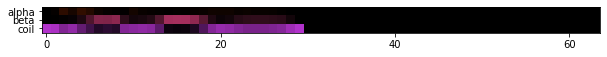

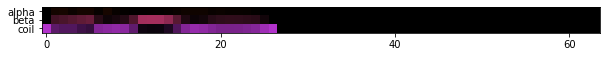

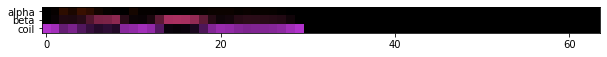

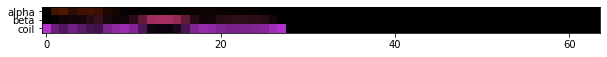

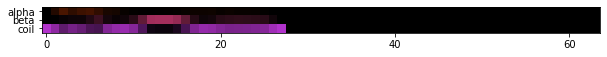

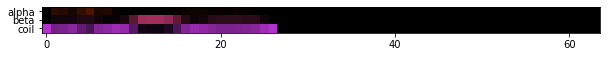

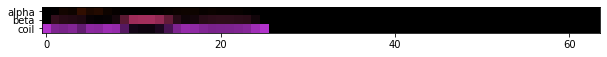

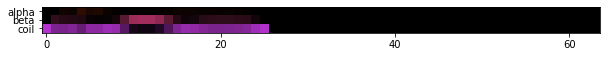

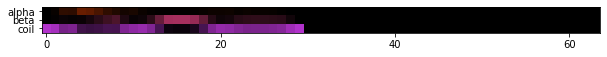

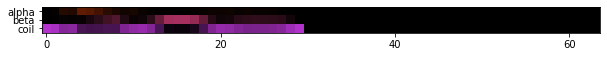

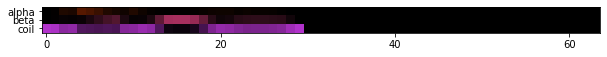

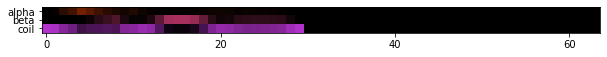

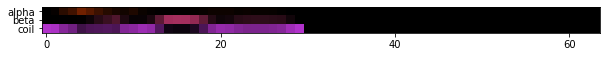

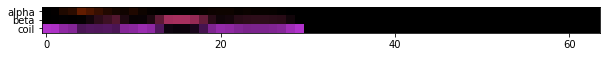

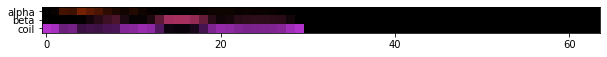

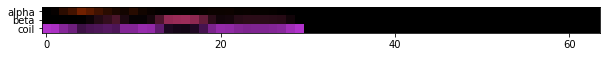

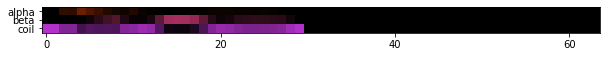

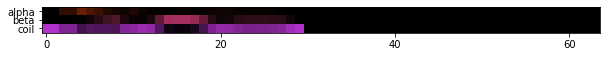

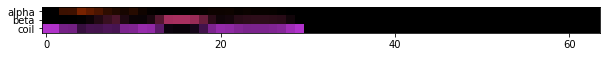

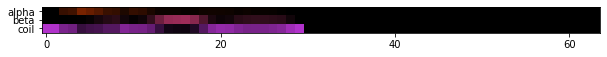

In [26]:
SIZE = 64

for i in range(20):
#     gt = np.array(val_dataset[i][2][:,-1],dtype=int)
    N = potentials[i].shape[0]
    q, r = N//SIZE, N%SIZE
    j = 0
    for j in range(q):
        fig = plt.figure(figsize=(10,3))
        p = potentials[i][SIZE*j:SIZE*(j+1)]
        mapping = np.array([to_map(p,i) for i in range(3)])
        plt.xticks(list(range(0,SIZE,20)), list(range(SIZE*j,SIZE*(j+1),20)))
        plt.yticks([0,1,2],["alpha", "beta", "coil"])
        plt.imshow(mapping)

    fig = plt.figure(figsize=(10,3))
    p = np.pad(potentials[i][-r:], ((0,SIZE-r),(0,0)))
    mapping = np.array([to_map(p,i) for i in range(3)])
    plt.xticks(list(range(0,SIZE,20)), list(range(SIZE*j,SIZE*(j+1),20)))
    plt.yticks([0,1,2],["alpha", "beta", "coil"])
    plt.imshow(mapping)


In [10]:
pickle.dump(potentials, open(f"{DATA}/{DATASET}/ss3_spec.pkl", "wb"))

In [17]:
len(potentials)

54025

## Denoiser

In [149]:
from secondary_structure.model import ResBlock, leaky_relu, ConvBlock

class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()

        self.conv1 = ConvBlock(nn.Conv1d, None, None, 
                                3, 3, 257,
                                stride=1, padding=128, bias=True)
#         self.conv2 = ConvBlock(nn.Conv1d, leaky_relu, nn.BatchNorm1d, 
#                                 32, 64, 129,
#                                 stride=1, padding=64, bias=True)  
#         self.conv3 = ConvBlock(nn.Conv1d, leaky_relu, nn.BatchNorm1d, 
#                         64, 3, 129,
#                         stride=1, padding=64, bias=True)        

        

    def forward(self, x):
        h = self.conv1(x)
#         h = self.conv2(h)
#         h = self.conv3(h)
        return h

In [150]:
def seq_acc(pred, target):
    return (pred.argmax(1) == target).sum()

def train_denoiser(epoch):
    start = time.time()
    denoiser.train()
    train_loss, train_acc, n_res = 0, 0, 0
    for batch_idx, data in enumerate(train_loader):
        t = data[2].float().permute(0, 2, 1)[:, -1].long()
        B,N = t.size()
        
        x = t.clone().view(1,1,-1)
        perm = torch.randperm(N)
        idx = perm[:N//10]
        changes = torch.randint(2, size = (N//10,))
        x[0,0,idx] = changes
        x_onehot = torch.zeros(B,3,N)
        x_onehot[0, x[0,0], torch.arange(N)] = 1
        
        optimizer.zero_grad()
        y = denoiser(x_onehot.cuda()).cpu()
        loss = F.cross_entropy(y, t)
        loss.backward()
        train_loss += loss.item()/len(data)
        optimizer.step()
        
        acc = seq_acc(y, t).float()
        train_acc = (train_acc * n_res + acc)/(n_res+N)
        n_res += N
        print(f'''Train Epoch: {epoch} [{100. * batch_idx / len(train_loader):.0f}%] || Loss: {train_loss/(batch_idx+1):.2f} || Time: {time.time()-start:.2f}s || Acc: {train_acc:.4f}''', end="\r")
        
    print(f'''Train Epoch: {epoch} [100%] || Loss: {train_loss/(batch_idx+1):.2f} || Time: {time.time()-start:.2f}s || Acc: {train_acc:.4f}''')
    
def val_denoiser(epoch):
    start = time.time()
    denoiser.eval()
    val_loss, val_acc, n_res = 0, 0, 0
    for batch_idx, data in enumerate(val_loader):
        t = data[2].float().permute(0, 2, 1)[:, -1].long()
        B,N = t.size()
        
        x = t.clone().view(1,1,-1)
        perm = torch.randperm(N)
        idx = perm[:N//10]
        changes = torch.randint(2, size = (N//10,))
        x[0,0,idx] = changes
        x_onehot = torch.zeros(B,3,N)
        x_onehot[0, x[0,0], torch.arange(N)] = 1
                
        y = denoiser(x_onehot.cuda()).cpu()
        loss = F.cross_entropy(y, t)

        val_loss += loss.item()/len(data)
        acc = seq_acc(y, t).float()
        val_acc = (val_acc * n_res + acc)/(n_res+N)
        n_res += N
    print(f'''Val Epoch: {epoch} || Loss: {val_loss/(batch_idx+1):.2f} || Time: {time.time()-start:.2f}s || Acc: {val_acc:.4f}''')


In [153]:
N, qx, qs, h = 128, 50, 3, 8
# del model
device = torch.device('cuda')

# del model
denoiser = Denoiser()
denoiser = denoiser.to(device)
optimizer = optim.Adam(denoiser.parameters(), lr=0.001)
start = time.time()

denoiser

Denoiser(
  (conv1): ConvBlock(
    (conv): Conv1d(3, 3, kernel_size=(257,), stride=(1,), padding=(128,))
  )
)

In [154]:
for i in range(10):
    train_denoiser(i)
    val_denoiser(i)

Train Epoch: 0 [100%] || Loss: 0.04 || Time: 14.07s || Acc: 0.9563
Val Epoch: 0 || Loss: 0.03 || Time: 1.74s || Acc: 0.9703
Train Epoch: 1 [100%] || Loss: 0.03 || Time: 16.24s || Acc: 0.9696
Val Epoch: 1 || Loss: 0.03 || Time: 1.42s || Acc: 0.9690
Train Epoch: 2 [100%] || Loss: 0.03 || Time: 13.09s || Acc: 0.9696
Val Epoch: 2 || Loss: 0.03 || Time: 1.36s || Acc: 0.9692
Train Epoch: 3 [100%] || Loss: 0.03 || Time: 14.10s || Acc: 0.9695
Val Epoch: 3 || Loss: 0.03 || Time: 1.49s || Acc: 0.9704
Train Epoch: 4 [100%] || Loss: 0.03 || Time: 14.78s || Acc: 0.9696
Val Epoch: 4 || Loss: 0.03 || Time: 1.52s || Acc: 0.9693
Train Epoch: 5 [100%] || Loss: 0.03 || Time: 14.07s || Acc: 0.9698
Val Epoch: 5 || Loss: 0.03 || Time: 1.43s || Acc: 0.9700
Train Epoch: 6 [100%] || Loss: 0.03 || Time: 14.43s || Acc: 0.9698
Val Epoch: 6 || Loss: 0.03 || Time: 1.53s || Acc: 0.9698
Train Epoch: 7 [100%] || Loss: 0.03 || Time: 14.21s || Acc: 0.9698
Val Epoch: 7 || Loss: 0.03 || Time: 1.40s || Acc: 0.9700
Train Ep

KeyboardInterrupt: 